In [1]:

import os
import re
import warnings
warnings.filterwarnings("ignore") #ignores all warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import gc

import re
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

import distance

# %matplotlib inline this makes all the graph appear in the notebook and not in seperate windows

In [2]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv("df_fe_without_preprocessing_train.csv",encoding ='latin-1')
    df=df.fillna('')
    df.head()
else:
    print("no file found")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_quid1,freq_quid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_qid1,freq_qid2,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12.0,23.0,0.434783,1,1,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,8.0,20.0,0.200000,4,1,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,14.0,24.0,0.166667,1,1,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,10.0,19.0,0.000000,1,1,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,13.0,20.0,0.100000,3,1,4,2


# Preprocessing of text
* Preprocessing
    * Removing HTML tags
    * Removing Punctuation
    * Performing Stemming
    * Removing Stopwords
    * Expanding contractions etc.



In [47]:
SAFE_DIV = 0.0001

STOP_WORDS = stopwords.words('english') # in sentence: This is very tasty. This and is are stopwords since without them also we have a broad meaning of the sentence

def preprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  # re (regular expression) , sub is used to replace a substring with other
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile("\W")  # used to compile regular expression.pattern now strores all the unicode word characters like(a-z,A-Z,0-9,<,> and symbols)
    
    if type(x) == type(''):  # to check whether x is string
        x=re.sub(pattern,' ',x)  # replace all the unicode character with space. can be used to remove HTML tags.
    
    if type(x) == type(''):
        x=porter.stem(x)  # changing words to there root ex- liked to like, waited to wait
        example1= BeautifulSoup(x) # Beautiful Soup is a Python library for pulling data out of HTML and XML files
        x=example1.get_text()
    
    return x;

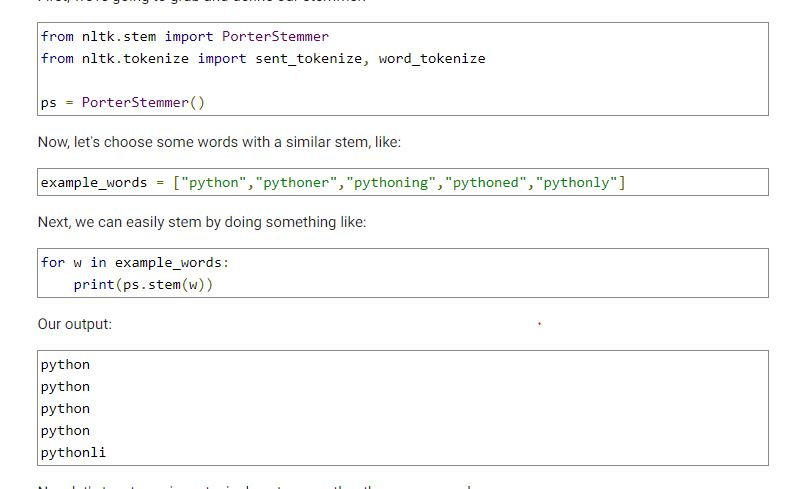

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


# We will use the following technique to find the similarity b/w sentences
* fuzz_rato
* fuzz_partial_ratio
* token_sort_ratio
* token_set_ratio
* Longest set ratio

For details see onenote.

In [48]:
def get_token_features(q1,q2):
    token_features = [0.0]*10  # token_features = [0.0, 0.0 ..... 10 times], this is the basically the new columns for the dataset
    
    #converting sentences into tokens
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # get the nonstop words in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #get the stop words in questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #get the common non_stopwords from the question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    #Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    #Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    # SAFE_DIV = 0.0001
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
     # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features
    
# get the longest common sub string
    
def get_longest_substr_ratio(a,b):
    strs = list(distance.lcsubstrings(a,b))  # it returns a set with one element i.e LCS .We convert it to a list
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0])/ (min(len(a), len(b)) + 1)
    
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    print("token features...")
    # Merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    print("fuzzy features")
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [49]:
import warnings
from fuzzywuzzy import fuzz
warnings.filterwarnings("ignore") #ignores all warnings
from fuzzywuzzy import fuzz
df = extract_features(df)
df.to_csv('nlp_features_train.csv',index =False)
df.head(2)

token features...
fuzzy features


,id,qid1,qid2,question1,question2,is_duplicate,freq_quid1,freq_quid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [50]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8') # without adding the encoding there were some errors.
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [51]:
# reading gte text files and removing the stop words:

d=os.path.dirname(".")

textp_w = open(os.path.join(d, 'train_p.txt'),encoding='utf-8').read()  # adding encoding here is very important since we saved txt in encoding='utf-8'
textn_w = open(os.path.join(d, 'train_n.txt'),encoding='utf-8').read()
stopwords = set(STOP_WORDS)
stopwords.add('said')
stopwords.add('br')
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove('no')
#stopwords.remove('like')

print('Total number of words in duplicate pair questions : ',len(textp_w))
print("Total number of words in non duplicate pair questions : ", len(textn_w))

Total number of words in duplicate pair questions :  16110116
Total number of words in non duplicate pair questions :  33211241


__ Word Clouds generated from  duplicate pair question's text __

Word cloud for duplicate question pairs


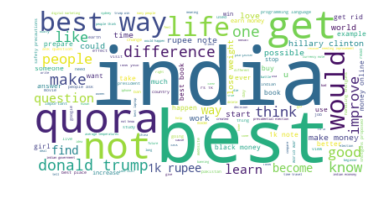

In [52]:
from wordcloud import WordCloud
wc= WordCloud(background_color ='white', max_words = len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
print('Word cloud for duplicate question pairs')
plt.imshow(wc,interpolation ='bilinear')
plt.axis('off')
plt.show()

Word Cloud for non-Duplicate Question pairs:


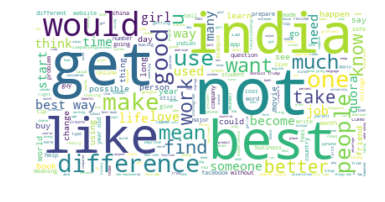

In [53]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

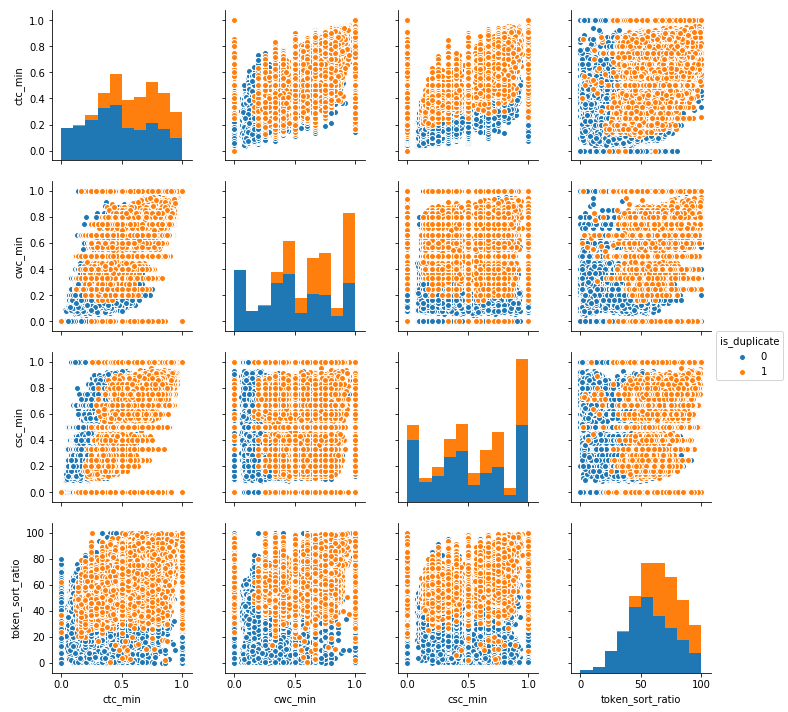

In [54]:
df=pd.read_csv("nlp_features_train.csv")
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
# first before the comma is the dataset. We have reduced it to a small dataframe, hue is the field where we want different colours\
# wrt to values of the field. vars are the x and y variable fields for the graphs
plt.show()

In [3]:
df=pd.read_csv("nlp_features_train.csv")

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



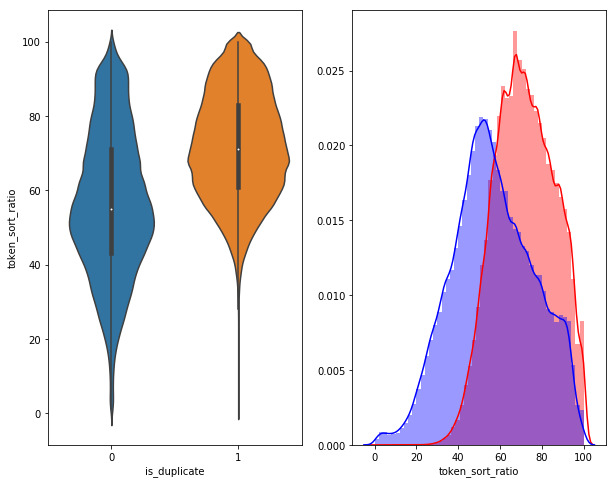

In [4]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\RISHAB MALLICK\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



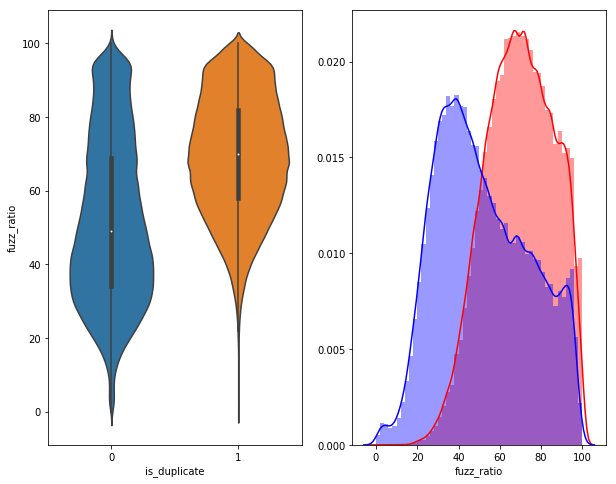

In [5]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>Visualization </h3>

In [6]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
x = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']]) 
y = dfp_subsampled['is_duplicate'].values 

#MinMaxScaler will convert the columns data to a range. Default is 0 ot 1
# fit_transform is a join between fit(to find the parameters like mean and variance of the column) and transform(fill the Nan spaces with the values found in fit)

In [9]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.377s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130404
[t-SNE] Computed conditional probabilities in 0.222s
[t-SNE] Iteration 50: error = 81.3123093, gradient norm = 0.0405594 (50 iterations in 6.136s)
[t-SNE] Iteration 100: error = 70.6131210, gradient norm = 0.0105509 (50 iterations in 4.563s)
[t-SNE] Iteration 150: error = 68.9291916, gradient norm = 0.0060097 (50 iterations in 4.355s)
[t-SNE] Iteration 200: error = 68.1348190, gradient norm = 0.0049260 (50 iterations in 4.434s)
[t-SNE] Iteration 250: error = 67.6348495, gradient norm = 0.0040182

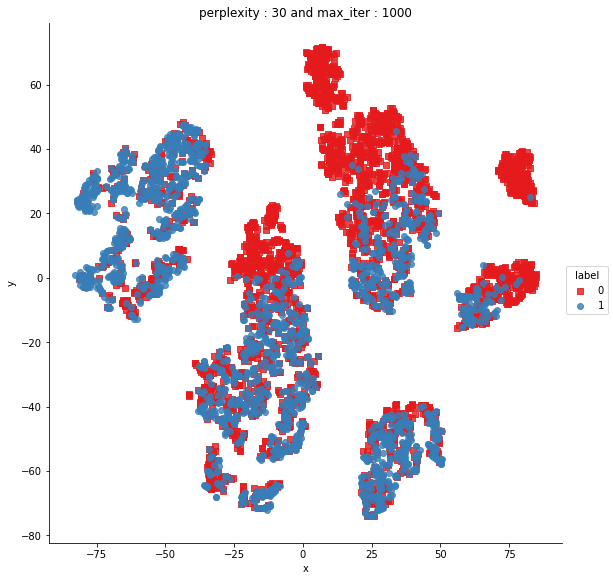

In [11]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1], 'label':y})    #df[row indexer, column indexer] since we have reduced the 15 dim to 2 dim tsne object so it has 2 col and n rows
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()